<a href="https://colab.research.google.com/github/nima-abdpoor/snapfood_satisfaction/blob/main/SnapFood_Satisfaction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.layers import Embedding
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import io
from google.colab import files
import gensim
from gensim.models.word2vec import Word2Vec
#!pip install hazm
#!pip install tensorflow
from hazm import word_tokenize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Bidirectional, SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import keras
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report




In [ ]:
#  tfds.disable_progress_bar()


In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Setup input pipeline

In [ ]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True )
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

In [5]:
uploaded = files.upload()


Saving dev.csv to dev.csv
Saving train.csv to train.csv


In [6]:
train = pd.read_csv(io.BytesIO(uploaded['train.csv']),sep='\t')
dev = pd.read_csv(io.BytesIO(uploaded['dev.csv']), sep='\t')
train.comment = train.comment.astype('str')
train.label = train.label.astype('str')


In [7]:
train

,Unnamed: 0,comment,label,label_id
0,0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0
...,...,...,...,...
56695,56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0
56696,56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0
56697,56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0
56698,56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0


In [8]:
dev

,Unnamed: 0,comment,label,label_id
0,0,همه ساندویچ‌ها سرد بود متاسفانه در صورتی که فا...,SAD,1
1,1,تشکر، عالی‌تر از همیشه,HAPPY,0
2,2,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...,HAPPY,0
3,3,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد؟؟؟,SAD,1
4,4,یک نوشابه کم ارسال شد و تاخیر فراوان و غذای نس...,SAD,1
...,...,...,...,...
6295,6295,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1
6296,6296,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1
6297,6297,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0
6298,6298,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1


In [28]:
labelencoder = LabelEncoder()
train['label'] = labelencoder.fit_transform(train['label'])
labelencoder = LabelEncoder()
dev['label'] = labelencoder.fit_transform(dev['label'])

In [9]:
# train.comment = train.comment.astype('str')
# train.label = train.label.astype('str')

In [58]:
data = []
#Splitting pd.Series to list
data_to_list = train['comment'].values.tolist()
for i in range(len(data_to_list)):
    data.append(data_to_list[i])

print(data[:5])

# ##
# data2 = []
# #Splitting pd.Series to list
# data_to_list2 = dev['comment'].values.tolist()
# for i in range(len(data_to_list2)):
#     data2.append(data_to_list2[i])
# ##


['واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح', 'قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون', 'قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ', 'عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم', 'شیرینی وانیلی فقط یک مدل بود.']


In [61]:
# converting each sentence to list of words and inserting in sents
sents = [word_tokenize(comment) for comment in data]
# sents2 = [word_tokenize(comment2) for comment2 in data2]

# print(len(sents))
# print(len(sents2))
# for x in sents2:
#   sents.append(x)
# print(len(sents))

# ##
# sents2 = [word_tokenize(comment2) for comment2 in data2]
# ##
# example
sents[45]

56700
6300
63000


In [62]:
model = Word2Vec(sentences=sents, size=64, window=10, min_count=5, seed=42, workers=5)

# ##
# model2 = Word2Vec(sentences=sents2, size=64, window=10, min_count=5, seed=42, workers=5)
# ##

In [63]:
model['غذا']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.7722448 ,  0.15813169, -0.52887744, -1.343591  , -0.048568  ,
       -3.2253113 ,  1.0574886 , -1.2952148 ,  0.92432153,  0.15637825,
        1.0893936 , -1.1185427 ,  0.45244706,  1.4237958 , -0.6708109 ,
        2.3398492 , -0.29240832,  1.926614  ,  1.5579674 , -2.0345395 ,
        0.35048902, -1.4782337 ,  0.1700936 , -1.1878986 , -0.02931272,
        1.7985348 ,  0.685824  ,  0.28259772,  1.2931352 , -0.46163476,
       -1.2839495 ,  1.5809028 , -0.35760498,  2.066579  ,  0.8014143 ,
       -1.1626992 , -1.6053163 ,  3.7723117 ,  1.1093502 ,  1.3634199 ,
       -0.45125163, -1.1823204 ,  1.467397  ,  2.1716459 ,  0.55156285,
        2.3037136 ,  2.9270062 ,  3.0996895 ,  2.8787327 ,  0.6109014 ,
        0.6204899 ,  0.7749071 ,  0.7482893 , -0.40786135,  1.8831886 ,
        2.0177305 , -0.36313218, -1.2814934 , -2.3509862 ,  2.5214105 ,
       -1.1251485 ,  4.221677  , -0.62203115,  0.70896065], dtype=float32)

In [64]:
# Let's check out most similar words to 'غذا'
model.most_similar('غذا', topn=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('غذای', 0.6463292241096497),
 ('غدا', 0.6376239061355591),
 ('غذا\u200cها', 0.5715185403823853),
 ('غذاها', 0.5670516490936279),
 ('برنج', 0.4982881247997284),
 ('جوجه', 0.4898064136505127),
 ('کباب', 0.47752198576927185),
 ('سرد', 0.47446244955062866),
 ('غذاش', 0.45407208800315857),
 ('رستوران', 0.4495995044708252),
 ('کباب\u200cها', 0.4470275938510895),
 ('پیتزا', 0.4468003809452057),
 ('ساندویچ', 0.43040862679481506),
 ('هوا', 0.4287498891353607),
 ('مسافت', 0.4105474352836609)]

In [65]:
# Another example
model.most_similar('عالی', topn=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('لذیذ', 0.7624168395996094),
 ('عالى', 0.7566364407539368),
 ('عاااالی', 0.7531619071960449),
 ('خوشمزه', 0.7490714192390442),
 ('خوب', 0.7388907670974731),
 ('خوش', 0.7355663776397705),
 ('عالیه', 0.6844447255134583),
 ('عااالی', 0.6480269432067871),
 ('بینظیر', 0.6468808650970459),
 ('باکیفیت', 0.6441835761070251),
 ('دلچسب', 0.6270902156829834),
 ('تمیز', 0.618931770324707),
 ('خوبتون', 0.6174615621566772),
 ('چسبید', 0.6073415875434875),
 ('معرکه', 0.5760904550552368)]

In [66]:
#print(model.wv.vocab)

{'واقعا': <gensim.models.keyedvectors.Vocab object at 0x7efdcb006190>, 'حیف': <gensim.models.keyedvectors.Vocab object at 0x7efdb5799510>, 'وقت': <gensim.models.keyedvectors.Vocab object at 0x7efdcbd17890>, 'که': <gensim.models.keyedvectors.Vocab object at 0x7efdcafbd290>, 'بنویسم': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1ed0>, 'سرویس': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a15d0>, 'دهیتون': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1e10>, 'شده': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1cd0>, 'افتضاح': <gensim.models.keyedvectors.Vocab object at 0x7efdcafbd190>, 'قرار': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1390>, 'بود': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1450>, '۱': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1110>, 'ساعته': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a12d0>, 'برسه': <gensim.models.keyedvectors.Vocab object at 0x7efdaa4a1d50>, 'ولی': <gensim.models.keyedvector

In [67]:
# total numberof extracted words.
vocab=model.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  7858


In [68]:
# print(vocab)
vocab=list(vocab.keys())

In [69]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size

The no of key-value pairs :  7858


In [70]:
tok = Tokenizer()
tok.fit_on_texts(train['comment'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(train['comment'])

In [71]:
for x in range(10):
  print(train['comment'].iloc[x])
  print(encd_rev[x])

واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
[23, 442, 302, 5, 3603, 364, 4320, 14, 160]
قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون
[340, 1, 215, 1258, 366, 15, 191, 76, 420, 4, 93, 350, 115, 6740, 15059, 1419, 15060, 19, 3269, 7577, 2, 3269, 49, 6741, 556, 1203]
قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ
[59, 17, 532, 25, 10, 239, 15061, 1886, 27, 705, 10915, 1522, 8845, 727, 434, 2, 161]
عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم
[6742, 1, 50, 291, 209, 2, 3, 205, 2, 9, 928, 15062, 35, 1198, 11, 98, 105, 104, 581, 4321]
شیرینی وانیلی فقط یک مدل بود.
[82, 1379, 27, 30, 532, 1]
بدترین پیتزایی که تا به حال خورده بودم
[352, 666, 5, 41, 3, 435, 269, 46]
از همه لحاظ عالی ممنونم
[4, 50, 567, 12, 122]
کیفیت غذا متوسط رو به پایین بود انگار داخل یه رستوران معمولی غذا خوردی درحالی که ا

In [72]:
all_lens = []
for x in encd_rev:
  all_lens.append(len(x))
print(max(all_lens))

361


In [73]:
max_rev_len = max(all_lens)  # max lenght of a comment
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=64 # embedding dimension as choosen in word2vec constructor
print(vocab_size)

34165


In [74]:
# now padding to have a amximum length of 361
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape   # note that we had 100K reviews and we have padded each review to have  a lenght of 361 words.

(56700, 361)

In [75]:
print(pad_rev)

[[  23  442  302 ...    0    0    0]
 [ 340    1  215 ...    0    0    0]
 [  59   17  532 ...    0    0    0]
 ...
 [  51   35  413 ...    0    0    0]
 [ 760 2453  601 ...    0    0    0]
 [ 120   34  832 ...    0    0    0]]


In [76]:
# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero.

In [77]:
# # checking.
print(len(embed_matrix))
print(embed_matrix[14])

34165
[ 1.19671607 -0.07034308 -0.73310959 -0.54499131  3.8988061  -2.08657146
 -1.20567143  1.08159733 -0.68442303  0.18205647 -0.76649159  0.45456439
  2.34451151  0.12111324 -0.52380693 -0.9822979  -1.02003503 -1.49999416
  4.36026573 -0.83845335 -0.81230891  0.05132035 -0.25279102  0.27580801
 -0.34879717 -2.3984673  -2.56231165  0.33315921 -0.5271011  -1.14568841
  4.50943756 -2.99632168  0.47816673  1.20428717 -2.68181896 -1.47676861
  0.84727746  1.25626814 -1.55784714  0.65769225 -0.07849838 -2.07186174
  0.04242929 -3.06376171 -0.83285195  1.08400428  1.31369007  0.62406999
 -0.46946749  1.38153493  0.40836784  1.69424677 -1.76468408  1.81977403
 -1.08533049 -0.93180811  0.36625007 -1.64968371  1.06380129 -1.40865552
  2.72162271  3.84579039  1.31558025  0.98403347]


In [78]:
# prepare train and val sets first
Y= to_categorical(train['label'])    # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.30,random_state=42)

In [79]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
#model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len))
#model(pad_rev)
# model.add(CuDNNLSTM(64,return_sequences=False)) # loss stucks at about 
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(64,activation='relu'))
#model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.

In [80]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 361, 64)           2186560   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,260,994
Trainable params: 2,260,994
Non-trainable params: 0
_________________________________________________________________


In [81]:
# compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [95]:
# specify batch size and epocj=hs for training.
epochs=3
batch_size=64

In [83]:
  # fitting the model.
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/3
621/621 [==============================] - 402s 641ms/step - loss: 0.3692 - accuracy: 0.8406 - val_loss: 0.3577 - val_accuracy: 0.8427
Epoch 2/3
621/621 [==============================] - 400s 644ms/step - loss: 0.3263 - accuracy: 0.8603 - val_loss: 0.3391 - val_accuracy: 0.8541
Epoch 3/3
621/621 [==============================] - 393s 633ms/step - loss: 0.3055 - accuracy: 0.8712 - val_loss: 0.3300 - val_accuracy: 0.8576


(0.0, 0.3723621115088463)

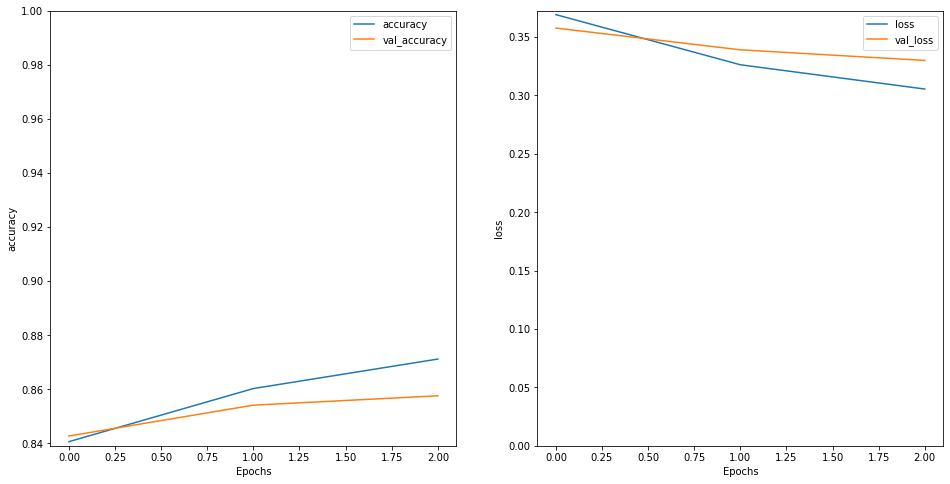

In [84]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [85]:
y_pred = model.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)


266/266 [==============================] - 37s 137ms/step


In [86]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [87]:
f1_reslut = f1_m(y_test, y_pred)
print(f1_reslut)

tf.Tensor(0.85766375, shape=(), dtype=float32)


In [88]:
sentiment = ['Neutral','Negative','Positive']
sequence = tok.texts_to_sequences(['مزخرف بود'])
test = pad_sequences(sequence, maxlen= max_rev_len)
model.predict(test)
predictions = model.predict(np.array(test))
print(predictions)
# sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

[[0.7016543 0.3392783]]


In [89]:
sequence = tok.texts_to_sequences(dev.comment)
test = pad_sequences(sequence, maxlen= max_rev_len)
predictions = model.predict(np.array(test))


In [111]:
print(sequence)

[[50, 813, 26, 1, 63, 16, 594, 5, 316, 41, 64, 187, 4, 351, 127, 108], [3437, 1907, 4, 35], [34, 2, 2461, 18, 1188, 303, 15, 154, 6400, 1013, 158], [312, 189, 55, 73, 3, 291, 480, 296, 11434], [30, 188, 33, 29, 61, 2, 124, 846, 2, 133, 538, 26], [251, 431, 6, 28, 108], [82, 10, 2305, 102, 42, 506, 1, 25, 51, 1005, 21], [577, 2202, 375, 336, 40, 29, 6, 88, 108, 316, 105, 10, 64, 88, 100], [25, 222, 1375, 10, 17, 50, 2936, 441, 305, 33, 98, 23, 77, 476, 21, 2, 134, 302, 74, 17, 225, 18, 5, 2327, 18, 1874, 199, 45, 2024, 27, 2936, 111, 106, 9, 30593, 112, 47, 106, 2451, 1, 106, 28, 472, 5, 556], [4, 888, 2411, 104, 349, 265, 2, 35, 4, 239, 77, 591, 44, 2622, 7, 9, 36, 14, 2, 7, 55, 73, 51, 102, 1017, 716, 7, 26, 620, 995, 7, 5, 3, 204, 819, 513, 1956, 729, 74, 132, 10, 349, 91, 4, 2285, 888, 14426, 228], [82, 9, 112, 54], [1880, 1603, 9083, 185, 35, 221], [10, 83, 2, 321, 377, 329, 846, 4, 133, 20, 28, 9, 2, 205, 20, 11, 1, 4, 1389, 45, 2024, 20, 122], [116, 113, 1076, 14, 2109, 264, 15, 

In [91]:
dev_y = to_categorical(dev['label'])
print(f1_m(dev_y ,predictions ))

tf.Tensor(0.49389282, shape=(), dtype=float32)
